# ML_MariaJoseCamacho - Predicción de Rotación de Empleados (Employee Attrition)
## **Paso 1: Entendiendo el problema**


"""
Este proyecto desarrolla un modelo de Machine Learning para predecir qué empleados tienen mayor probabilidad de abandonar una empresa ("Attrition"). Se trata de un problema de clasificación binaria, cuyo objetivo es anticipar la rotación laboral y facilitar decisiones estratégicas en recursos humanos.

Por último agruparemos los diferentes perfiles de los trabajadores mediante modelos no supervisados.
"""


## **Paso 2: Carga de librerías**


In [29]:
import pandas as pd
import numpy as np
import math                                                         
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import joblib

## **Paso 3: Carga de datos y viwsualización inicial**
(Selección de variables, tratamiento de nulos, escalado si es necesario)


In [2]:
# Cargar los datos de nuestro dataset
file_path = r"C:\Users\marij\Documents\dataset ML\WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(file_path)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# Esta es la dimensión del dataset total
df.shape

(1470, 35)

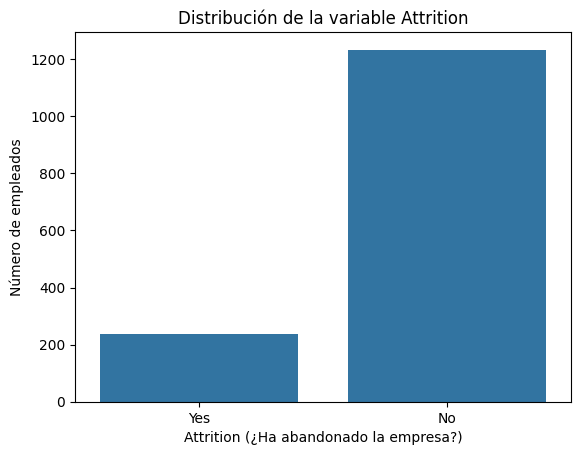

In [4]:
# Visualizamos la variable objetivo
sns.countplot(x='Attrition', data=df)
plt.title('Distribución de la variable Attrition')
plt.xlabel('Attrition (¿Ha abandonado la empresa?)')
plt.ylabel('Número de empleados')
plt.show()

In [5]:
# Conteo de la variable objetivo
print(df['Attrition'].value_counts())

# Porcentaje de cada valor de la variable
print(df['Attrition'].value_counts(normalize=True) * 100)

Attrition
No     1233
Yes     237
Name: count, dtype: int64
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


El dataset está desbalanceado (~16% abandonos), por lo que priorizaremos métricas como recall.

### 📄 Descripción de las variables del dataset

| Columna                     | Descripción                                                                 |
|-----------------------------|-----------------------------------------------------------------------------|
| **Age**                     | Edad del empleado.                                                          |
| **Attrition**               | Si el empleado ha abandonado la empresa (`Yes`) o no (`No`).               |
| **BusinessTravel**          | Frecuencia con la que el empleado viaja por trabajo.                        |
| **Department**              | Departamento en el que trabaja el empleado (Ventas, I+D, RRHH).             |
| **DistanceFromHome**        | Distancia (en millas) desde su casa al trabajo.                             |
| **Education**               | Nivel educativo (1=Menor, 5=Mayor).                                         |
| **EducationField**          | Área de formación (Ciencias, Marketing, Medicina, etc.).                    |
| **EnvironmentSatisfaction** | Grado de satisfacción con el entorno laboral (1 a 4).                      |
| **Gender**                  | Género del empleado.                                                        |
| **JobRole**                 | Cargo o puesto de trabajo específico.                                       |
| **JobSatisfaction**         | Grado de satisfacción con su trabajo (1 a 4).                               |
| **MaritalStatus**           | Estado civil (Soltero, Casado, Divorciado).                                |
| **MonthlyIncome**           | Ingreso mensual.                                                            |
| **NumCompaniesWorked**      | Número de empresas anteriores en las que ha trabajado.                      |
| **OverTime**                | Si realiza horas extra (`Yes` o `No`).                                      |
| **PercentSalaryHike**       | Porcentaje del último aumento salarial.                                    |
| **StockOptionLevel**        | Nivel de participación accionarial.                                        |
| **TotalWorkingYears**       | Años totales de experiencia laboral.                                        |
| **TrainingTimesLastYear**   | Número de formaciones completadas el último año.                           |
| **WorkLifeBalance**         | Equilibrio entre vida personal y trabajo (1=Malo, 4=Excelente).             |
| **YearsAtCompany**          | Años que lleva en la empresa.                                              |
| **YearsInCurrentRole**      | Años en su puesto actual.                                                  |
| **YearsSinceLastPromotion** | Años desde la última promoción.                                            |
| **YearsWithCurrManager**    | Años trabajando con el actual supervisor.                                   |


## **Paso 4: Análisis exploratorio (Mini EDA)**

En este paso exploramos la estructura y características principales del dataset para entender mejor la variable objetivo y las posibles relaciones con otras variables.



In [6]:
# Valores nulos
print(df.isnull().sum().sort_values(ascending=False).head())

Age               0
Attrition         0
BusinessTravel    0
DailyRate         0
Department        0
dtype: int64


In [7]:
# Estadísticas generales
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [8]:
# Correlación con variable objetivo binarizada
df["Attrition_bin"] = df["Attrition"].map({"Yes": 1, "No": 0})
correlaciones = df.corr(numeric_only=True)["Attrition_bin"].sort_values(ascending=False)
print(correlaciones)

Attrition_bin               1.000000
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
EmployeeNumber             -0.010577
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
EmployeeCount                    NaN
StandardHours                    NaN
N

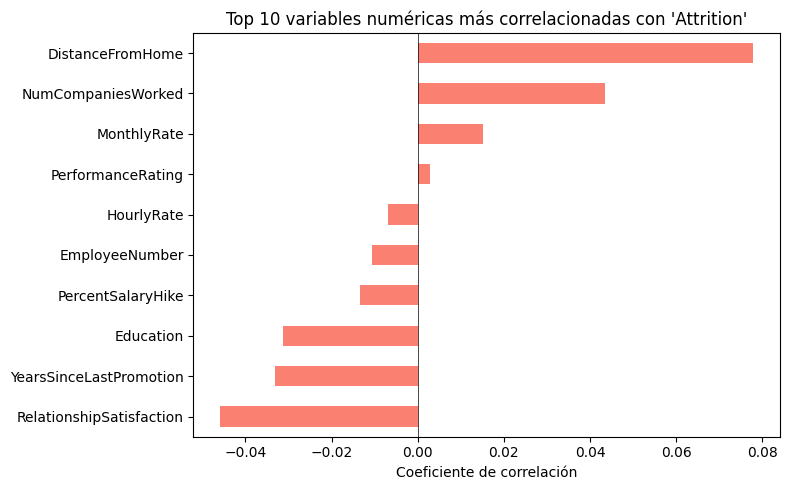

In [9]:
# Visualizamos las 10 variables numéricas más correlacionadas con la rotación
plt.figure(figsize=(8, 5))
correlaciones.drop("Attrition_bin").head(10).plot(kind='barh', color='salmon')
plt.title("Top 10 variables numéricas más correlacionadas con 'Attrition'")
plt.xlabel("Coeficiente de correlación")
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Tras analizar las correlaciones numéricas con la variable objetivo (`Attrition_bin`), observamos que algunas variables presentan coeficientes muy cercanos a cero, lo que indica que tienen poca o ninguna relación lineal con la rotación de empleados.

Variables como `EmployeeNumber`, `PerformanceRating`, `HourlyRate` o `PercentSalaryHike` muestran una correlación muy baja o negativa con `Attrition_bin`. Por ello, en el siguiente paso procederemos a **descartar estas variables consideradas poco relevantes** para mejorar la eficiencia y la interpretabilidad del modelo.

Esta eliminación se realizará antes del entrenamiento, asegurando que el modelo solo trabaje con variables con potencial predictivo.



In [10]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_bin'],
      dtype='object')

In [11]:
# Variables numéricas que eliminaremos por baja correlación o poca variabilidad
cols_a_eliminar = [
    'EmployeeCount',       # constante (1 para todos)
    'StandardHours',       # constante (80 para todos)
    'EmployeeNumber',      # ID único, no aporta info útil
    'Over18'               # si existe, generalmente constante
]

# Algunas variables con correlación casi nula o negativa pueden eliminarse también:
cols_baja_corr = [
    'PerformanceRating', 
    'HourlyRate', 
    'PercentSalaryHike', 
    'MonthlyRate', 
    'DailyRate', 
    'TrainingTimesLastYear'
]

cols_a_eliminar += cols_baja_corr

# Eliminamos esas columnas del dataframe para el análisis/modelado posterior
dfnew = df.drop(columns=cols_a_eliminar)

print(f"Columnas eliminadas: {cols_a_eliminar}")
dfnew.shape

Columnas eliminadas: ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18', 'PerformanceRating', 'HourlyRate', 'PercentSalaryHike', 'MonthlyRate', 'DailyRate', 'TrainingTimesLastYear']


(1470, 26)

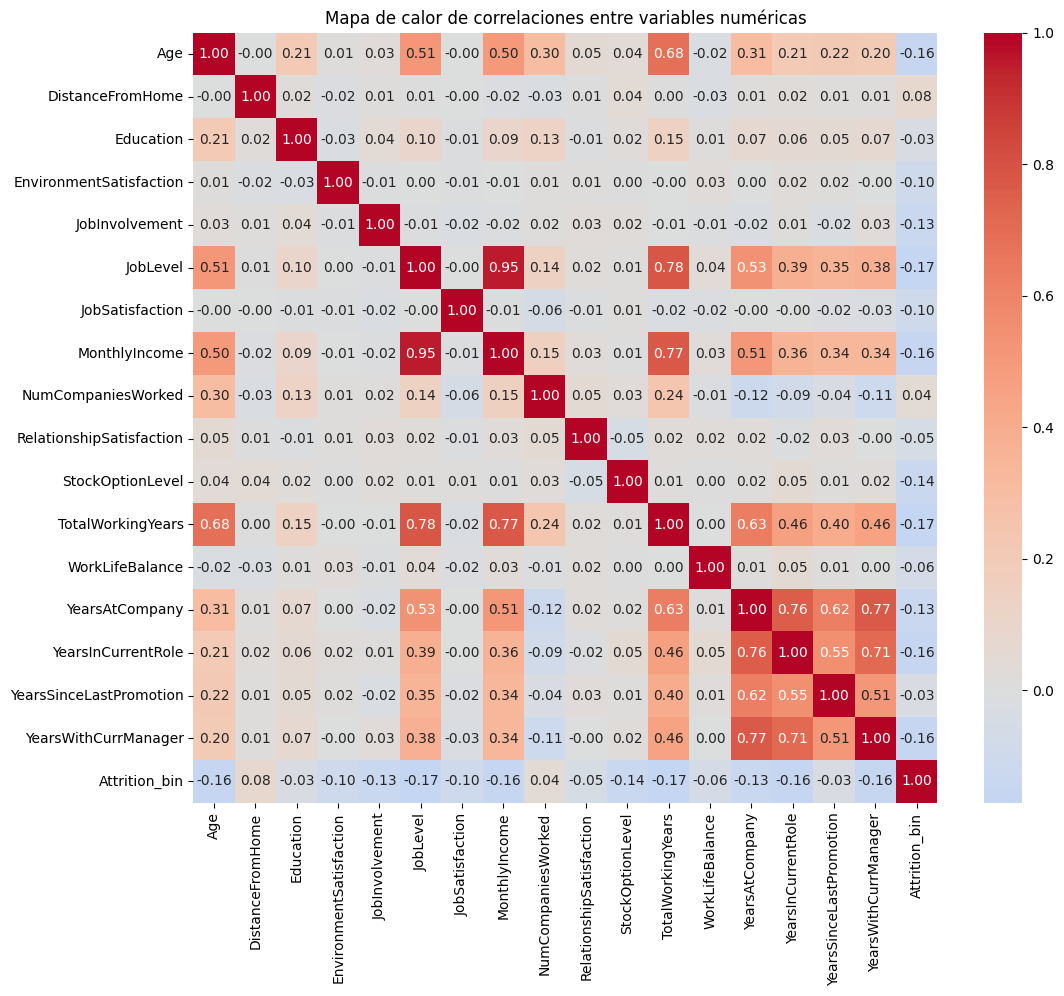

In [12]:
plt.figure(figsize=(12,10))
sns.heatmap(dfnew.select_dtypes(include=['int64', 'float64']).corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

### Interpretación del mapa de calor

- Las variables más asociadas con la rotación (`Attrition_bin`) son:
  - **JobLevel**, **MonthlyIncome**, **TotalWorkingYears**, **YearsAtCompany**, **JobInvolvement**, todas con coeficientes negativos, lo que indica que a mayor antigüedad, implicación o salario, menor probabilidad de abandono.
  
- Se observa **colinealidad** entre algunas variables:
  - `MonthlyIncome`, `JobLevel` y `TotalWorkingYears` están altamente correlacionadas (coeficientes > 0.75).
  - `YearsWithCurrManager` y `YearsInCurrentRole` también.
  
Estas relaciones deben considerarse al seleccionar variables o aplicar técnicas de reducción de dimensionalidad.


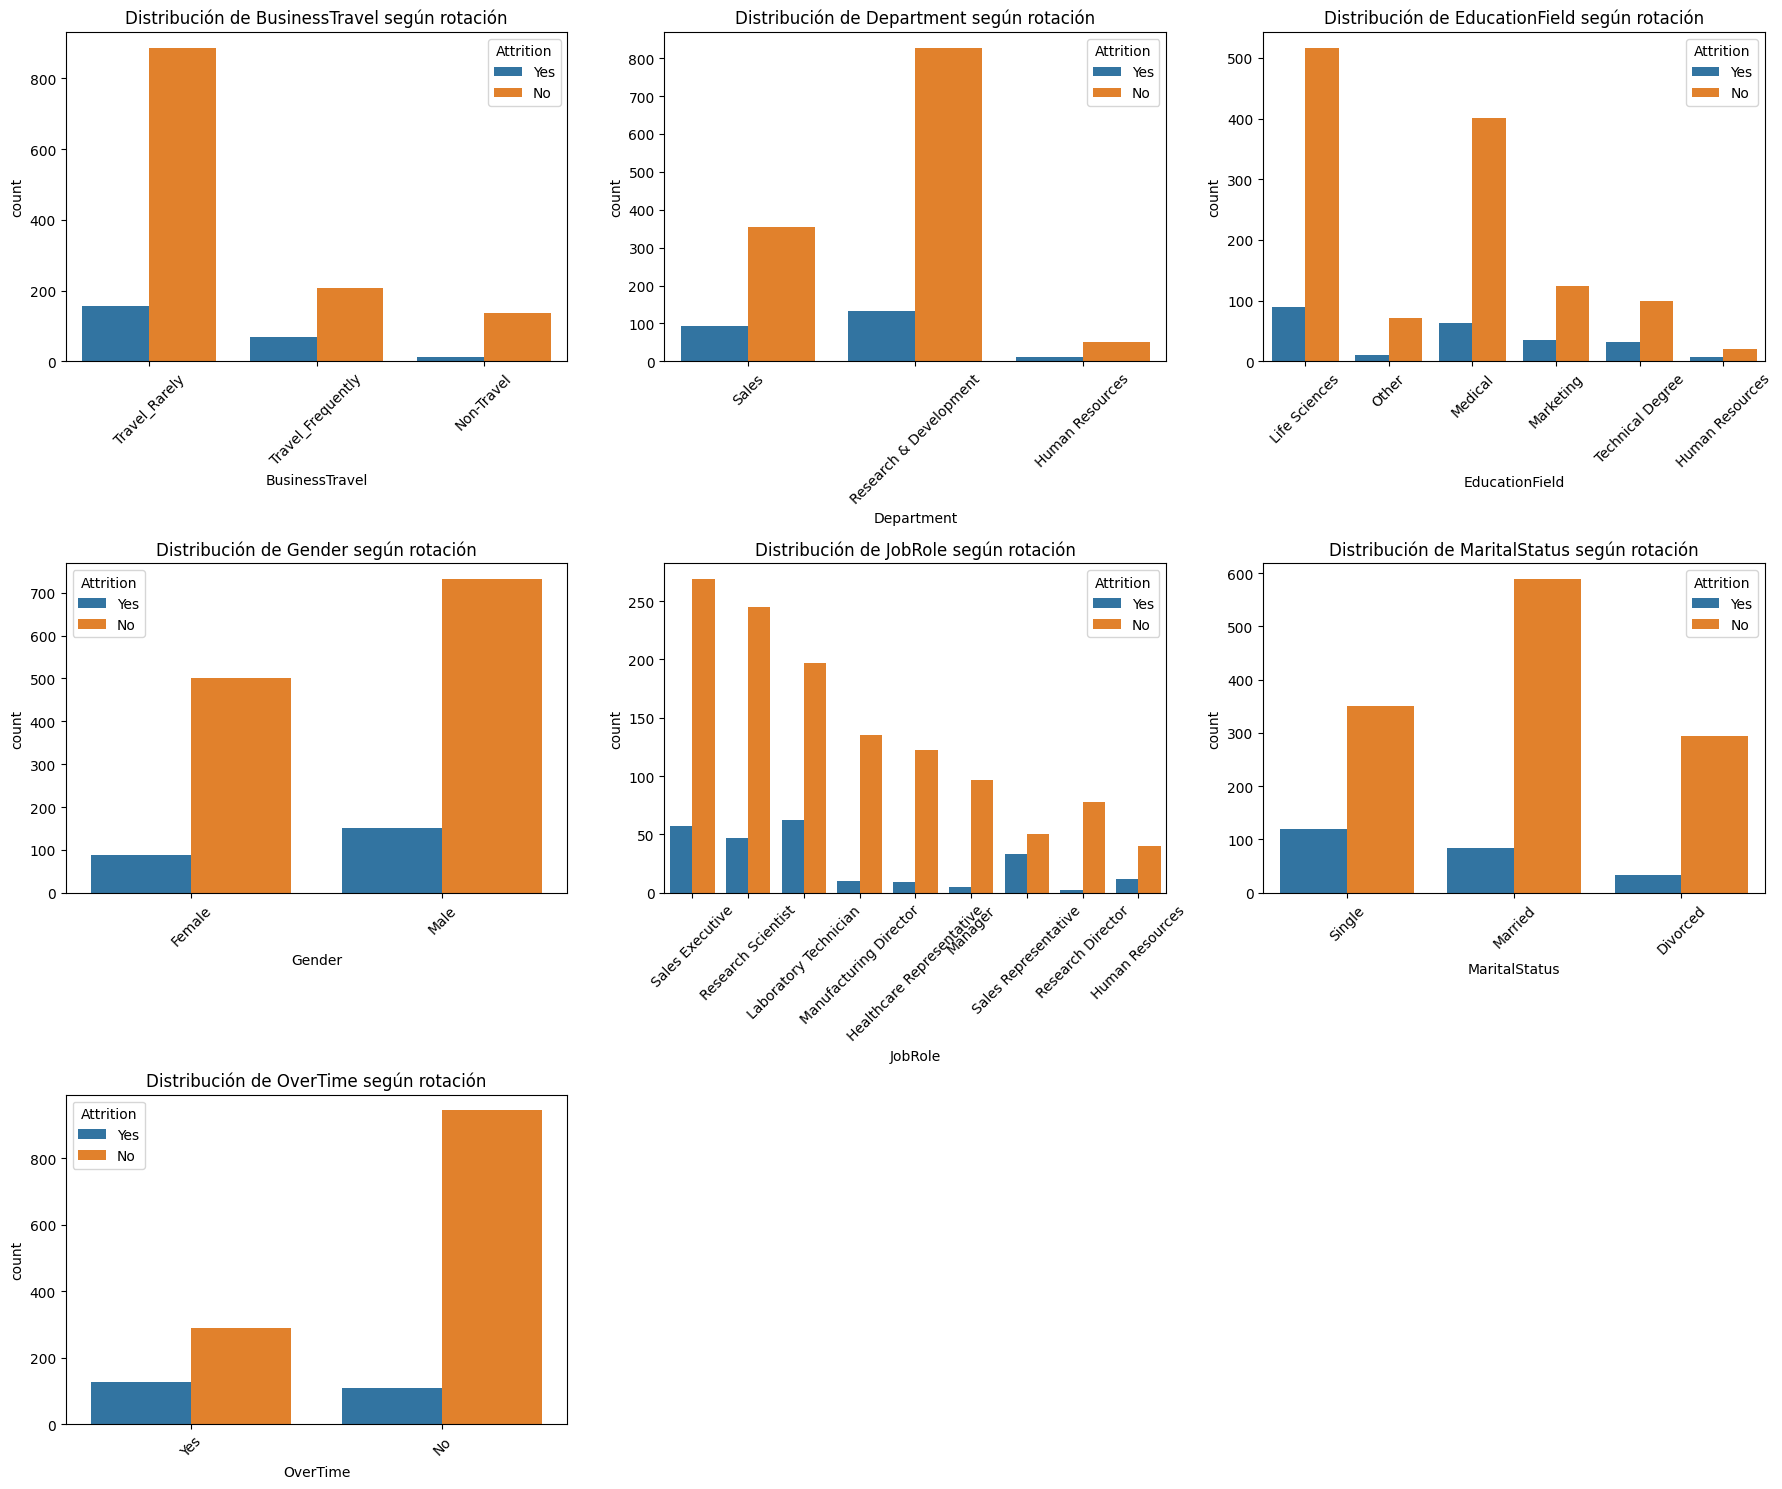

In [13]:
# Columnas categóricas excluyendo la variable objetivo
categorical_cols = dfnew.select_dtypes(include=['object']).columns.drop('Attrition')

# Definir número de columnas (por estética)
n_cols = 3
n_plots = len(categorical_cols)
n_rows = (n_plots + n_cols - 1) // n_cols  # redondeo hacia arriba sin usar math.ceil

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Visualizar
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='Attrition', data=dfnew, ax=axes[i])
    axes[i].set_title(f'Distribución de {col} según rotación')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Se observan diferencias claras en la distribución de la variable `Attrition` según varias variables categóricas.
- Empleados que hacen horas extra (`OverTime = Yes`), que viajan con frecuencia (`BusinessTravel = Travel_Frequently`) o que están solteros (`MaritalStatus = Single`) presentan una mayor proporción de abandono.
- Algunos roles (`JobRole`) y departamentos también muestran tendencias específicas en relación con la rotación.
- Estos patrones visuales sugieren que ciertas categorías están asociadas con un mayor riesgo de abandono, lo que justifica que la incluyamos para el modelado posterior.


In [ ]:
# Test Chi2 para las variables categoricas
for col in categorical_cols:
    tabla = pd.crosstab(dfnew[col], dfnew['Attrition'])
    chi2, p, dof, expected = chi2_contingency(tabla)
    print(f"↪ {col}: p-valor = {p:.4f}")
    if p < 0.05:
        print("   ✔ Asociación estadísticamente significativa con Attrition")
    else:
        print("   ✖ No hay asociación significativa con Attrition")
    print("-" * 60)

↪ BusinessTravel: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ Department: p-valor = 0.0045
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ EducationField: p-valor = 0.0068
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ Gender: p-valor = 0.2906
   ✖ No hay asociación significativa con Attrition
------------------------------------------------------------
↪ JobRole: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ MaritalStatus: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attrition
------------------------------------------------------------
↪ OverTime: p-valor = 0.0000
   ✔ Asociación estadísticamente significativa con Attritio

In [15]:
# Eliminamos la variable 'Gender' por no aportar información relevante al target
dfnew = dfnew.drop(columns='Gender')

# Confirmamos
print("Gender eliminado. Columnas actuales:")
dfnew.columns.tolist()

Gender eliminado. Columnas actuales:


['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'OverTime',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Attrition_bin']

### Conclusiones del test Chi-cuadrado

El test Chi-cuadrado confirma que **la mayoría de las variables categóricas analizadas presentan una asociación estadísticamente significativa con la rotación de empleados (`Attrition`)**:

- ✔ `BusinessTravel`, `Department`, `EducationField`, `JobRole`, `MaritalStatus` y `OverTime` tienen un **p-valor < 0.05**, lo que indica que las diferencias observadas en sus categorías respecto a la rotación **no son aleatorias**.
- ✖ La variable `Gender`, sin embargo, **no muestra una asociación significativa**, lo que sugiere que **el género no influye directamente en la decisión de abandonar la empresa** en este dataset.

Estos resultados respaldan la elección de las variables categóricas más relevantes para incluir en el preprocesamiento y posterior modelado.


In [34]:
# --------------------------
# 1. Definición de columnas categóricas y numéricas
# --------------------------
target = 'Attrition'

cat_features = []
num_features = []

for col in dfnew.columns:
    if col == target:
        continue
    if dfnew[col].dtype == 'object' or dfnew[col].dtype.name == 'category':
        cat_features.append(col)
    elif pd.api.types.is_numeric_dtype(dfnew[col]):
        num_features.append(col)

In [30]:

def plot_numeric_distributions(df, num_features, target, cols=3, kde=True):
    rows = math.ceil(len(num_features) / cols)
    plt.figure(figsize=(cols * 5, rows * 4))

    for i, col in enumerate(num_features):
        if df[col].nunique() <= 1:
            continue  # salta columnas constantes

        plt.subplot(rows, cols, i + 1)
        sns.histplot(
            data=df,
            x=col,
            hue=target,
            kde=kde,
            stat='density',
            common_norm=False,
            palette='Set2',
            alpha=0.6
        )
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel('Densidad')

    plt.tight_layout()
    plt.show()

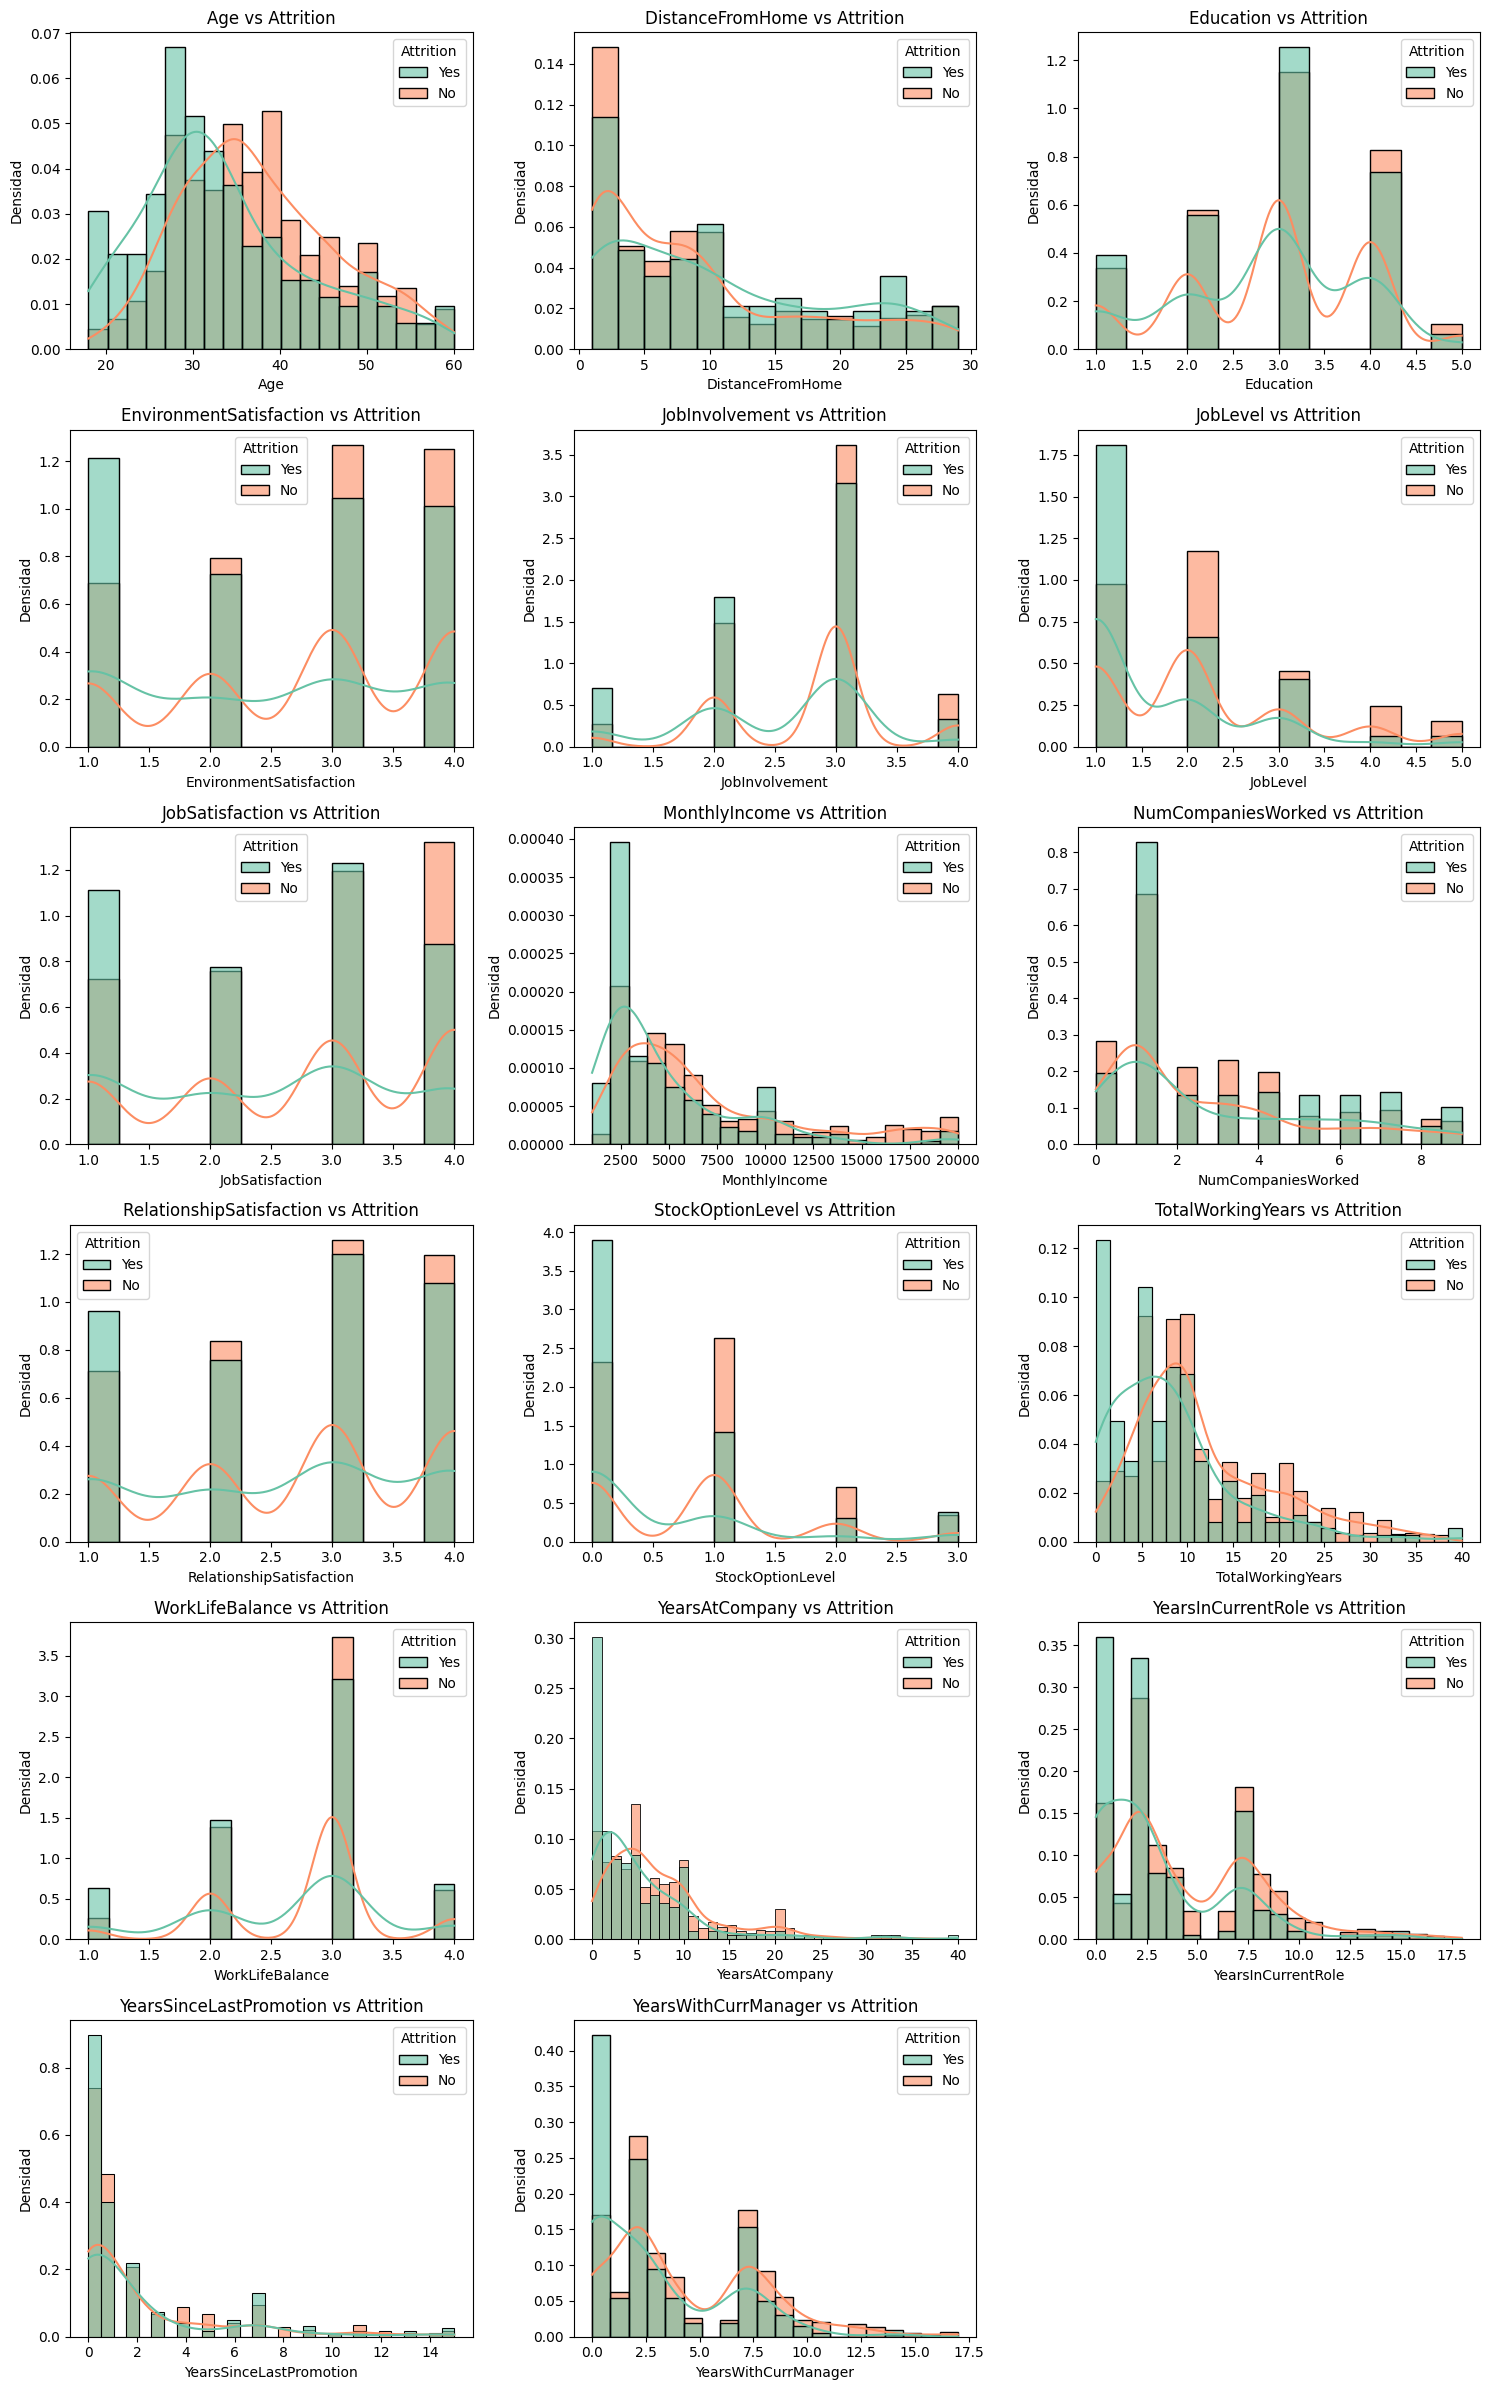

In [32]:
num_features = dfnew.select_dtypes(include=['int64', 'float64']).drop(columns='Attrition_bin').columns
plot_numeric_distributions(dfnew, num_features=num_features, target='Attrition')

## **Paso 5: Reducción de dimensiones (opcional)**
(PCA si decides usarlo para visualización o clustering)

## **Paso 6: Clustering**
(Entrenamiento del modelo: k-means, número óptimo de clusters, silhouette score…)

## **Paso 7: Interpretación de los grupos**
(Describir los perfiles encontrados, visualizarlos en 2D si usaste PCA o t-SNE)

## **Paso 8: Guardado del modelo**
(Exportar modelo entrenado en formato `.joblib` en `/src/models`)

## **Paso 9: Conclusiones**
(Resumen del proyecto y aplicaciones reales del análisis)